# Preprocessing & Visualization of 3D CT images

Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1001_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1002_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1005_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1008_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1009_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1012_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1013_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1018_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1019_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1025_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1026_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1029_CT.nii
Enhanced and sharpened pixel-wise mapping completed for: CRLM-CT-1030_CT.nii

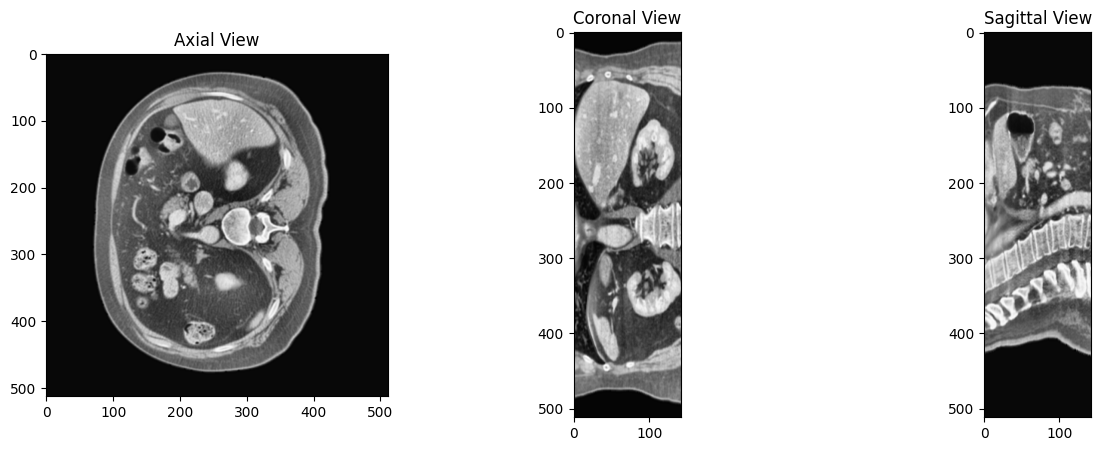

In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import morphology, exposure
from skimage.segmentation import clear_border
import cv2

# Set the input directory containing CT images in .nii format
input_directory = r"C:\Users\Asus\Desktop\CDU\transaction_project\nifti_files\ct"

# Set the output directory for saving preprocessed and enhanced images
output_directory = r"C:\Users\Asus\Desktop\CDU\transaction_project\preprocessed_images"

# Make sure the output directory exists
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Function to apply preprocessing steps to a single slice
def preprocess_slice(slice_data):
    try:
        # Clip data values to a specified range and normalize
        min_value = -1200
        max_value = 400
        slice_data[slice_data < min_value] = min_value
        slice_data[slice_data > max_value] = max_value
        normalized_data = (slice_data - min_value) / (max_value - min_value)

        # Apply windowing to adjust contrast and brightness
        window = 1000
        level = 250
        max_val = level + window / 2
        min_val = level - window / 2
        windowed_data = slice_data.clip(min_val, max_val)

        # Further clip data values to a narrower range
        min_val_clip = -800
        max_val_clip = 200
        clipped_data = windowed_data.clip(min_val_clip, max_val_clip)

        # Apply a morphological operation (clear_border)
        mask = clear_border(clipped_data)

        # Apply binary opening operation with 1 iteration using scipy
        opened_mask = ndimage.binary_opening(mask, iterations=3)

        # Apply binary dilation operation with 1 iteration using scipy
        dilated_mask = ndimage.binary_dilation(opened_mask, iterations=2)

        # Multiply the dilated mask with the original data
        preprocessed_slice = dilated_mask * normalized_data

        return preprocessed_slice

    except Exception as e:
        print(f"Error processing slice: {e}")
        return None

# Function to preprocess all slices in a 3D CT image and combine them into a 3D array
def preprocess_3d_ct(ct_data):
    preprocessed_slices = []
    for slice_idx in range(ct_data.shape[2]):
        preprocessed_slice = preprocess_slice(ct_data[:, :, slice_idx])
        if preprocessed_slice is not None:
            preprocessed_slices.append(preprocessed_slice)

    # Check if any slices were successfully processed
    if not preprocessed_slices:
        print("No valid slices found. Skipping preprocessing for this patient.")
        return None

    # Combine the preprocessed slices into a 3D array
    preprocessed_ct = np.stack(preprocessed_slices, axis=-1)

    return preprocessed_ct

# Function to apply local histogram equalization to enhance contrast
def apply_local_histogram_equalization(preprocessed_ct):
    enhanced_ct = np.zeros_like(preprocessed_ct)

    # Apply local histogram equalization to each slice
    for slice_idx in range(preprocessed_ct.shape[-1]):
        enhanced_slice = exposure.equalize_adapthist(preprocessed_ct[:, :, slice_idx], clip_limit=0.02)

        # Set pixels outside the region of interest to zero (black)
        enhanced_slice[preprocessed_ct[:, :, slice_idx] == 0] = 0

        enhanced_ct[:, :, slice_idx] = enhanced_slice

    return enhanced_ct

# Function to apply gamma correction to the enhanced 3D CT image
def apply_gamma_correction(enhanced_ct, gamma=1.5):
    gamma_corrected_ct = exposure.adjust_gamma(enhanced_ct, gamma=gamma)
    return gamma_corrected_ct

# Function to apply Gaussian blur to the image
def apply_gaussian_blur(image, sigma=1.0):
    blurred_image = cv2.GaussianBlur(image, (5, 5), sigma)
    return blurred_image

# Function to apply sharpening using unsharp masking
def apply_sharpening(image, alpha=1.0):
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    sharpened = cv2.addWeighted(image, 1 + alpha, blurred, -alpha, 0)
    return sharpened

# Function to display three views (axial, coronal, sagittal) of a 3D CT image
def display_three_views(ct_data):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axial_slice = ct_data[:, :, ct_data.shape[2] // 2]
    coronal_slice = ct_data[:, ct_data.shape[1] // 2, :]
    sagittal_slice = ct_data[ct_data.shape[0] // 2, :, :]

    axes[0].imshow(axial_slice, cmap="gray")
    axes[0].set_title("Axial View")
    axes[1].imshow(coronal_slice, cmap="gray")
    axes[1].set_title("Coronal View")
    axes[2].imshow(sagittal_slice, cmap="gray")
    axes[2].set_title("Sagittal View")

    plt.show()

# Loop through each .nii file in the input directory
for file_name in os.listdir(input_directory):
    if file_name.endswith(".nii"):
        input_path = os.path.join(input_directory, file_name)
        output_path = os.path.join(output_directory, f"preprocessed_{file_name}")

        # Load the NIfTI file
        try:
            image_data = nib.load(input_path)
            ct_data = image_data.get_fdata()
        except Exception as e:
            print(f"Error loading NIfTI file: {e}")
            continue

        # Preprocess all slices in the 3D CT image
        preprocessed_ct = preprocess_3d_ct(ct_data)

        # Check if preprocessing was successful
        if preprocessed_ct is not None:
            # Apply local histogram equalization to enhance contrast
            enhanced_ct = apply_local_histogram_equalization(preprocessed_ct)

            # Apply gamma correction
            gamma_corrected_ct = apply_gamma_correction(enhanced_ct, gamma=1.5)

            # Apply Gaussian blur
            blurred_ct = apply_gaussian_blur(gamma_corrected_ct, sigma=1.0)

            # Apply sharpening
            sharpened_ct = apply_sharpening(blurred_ct, alpha=1.0)

            # Save the enhanced and sharpened 3D CT image with the same dimensions
            try:
                nib.save(nib.Nifti1Image(sharpened_ct, image_data.affine), output_path)
            except Exception as e:
                print(f"Error saving enhanced and sharpened image: {e}")

            print(f"Enhanced and sharpened pixel-wise mapping completed for: {file_name}")

# Display three views of a random preprocessed CT image from the output directory
random_preprocessed_file = np.random.choice(os.listdir(output_directory))
random_preprocessed_path = os.path.join(output_directory, random_preprocessed_file)
random_preprocessed_data = nib.load(random_preprocessed_path).get_fdata()
display_three_views(random_preprocessed_data)


# High-Quality Pixel-Wise Mapping - GMM clustering

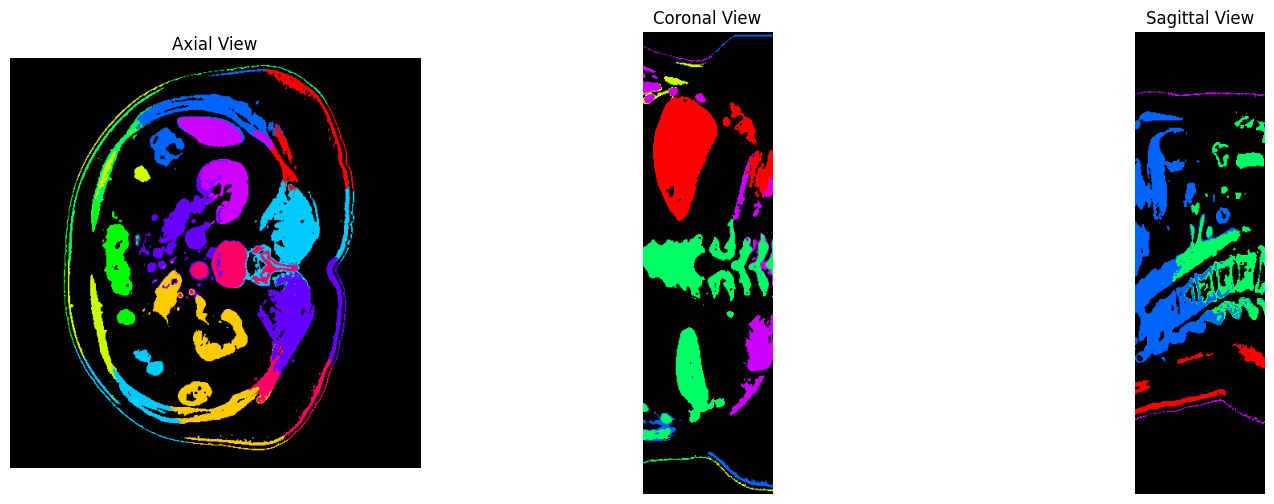

In [2]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from skimage import exposure, color, morphology
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Function to perform GMM clustering for a given slice
def gmm_clustering(slice_data):
    # Preprocess the slice
    slice_uint8 = (slice_data / slice_data.max() * 255).astype(np.uint8)
    equ = cv2.equalizeHist(slice_uint8)
    gamma_corrected = exposure.adjust_gamma(equ, gamma=1.5)
    
    # Apply morphological closing to enhance cluster shapes
    closed_data = morphology.binary_closing(gamma_corrected > 0.5, morphology.disk(3))
    
    # Get coordinates of each pixel
    height, width = gamma_corrected.shape
    y, x = np.mgrid[0:height, 0:width]
    
    # Reshape the image and coordinates for clustering
    reshaped_data = np.column_stack((gamma_corrected.ravel(), x.ravel(), y.ravel()))
    
    # Define the number of clusters (you can adjust this)
    k = 200
    
    # Apply Gaussian Mixture Model (GMM) clustering
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm.fit(reshaped_data)
    cluster_labels = gmm.predict(reshaped_data)
    
    # Create clustered image
    clustered_img = cluster_labels.reshape(gamma_corrected.shape)
    
    # Apply hierarchical clustering to group similar clusters
    linkage_matrix = linkage(gmm.means_, 'average')
    cluster_groups = fcluster(linkage_matrix, t=100, criterion='distance')
    
    # Create segmented image with distinct color clusters
    segmented_img = np.zeros((height, width, 3), dtype=np.uint8)
    
    # Assign distinct pixel intensities to different elements
    for i in range(k):
        cluster_pixels = gamma_corrected[clustered_img == i]
        
        # Set a threshold to consider only higher intensity regions
        threshold = 140  # You can adjust this threshold
        if np.mean(cluster_pixels) > threshold:
            # Assign a unique color to each cluster based on shape
            cluster_idx = cluster_groups[i]
            unique_color = np.array(color.hsv2rgb([cluster_idx * 360 / k, 1.0, 1.0]))
            segmented_img[clustered_img == i] = (unique_color * 255).astype(np.uint8)
    
    return segmented_img

# Set the input directory containing preprocessed CT images in .nii format
input_directory = r"C:\Users\Asus\Desktop\CDU\transaction_project\preprocessed_images"

# Specific patient file and slice numbers
patient_file = "preprocessed_CRLM-CT-1029_CT.nii"
axial_slice_number = 91
coronal_slice_number = 313
sagittal_slice_number = 271

# Load the NIfTI file
nii_img = nib.load(os.path.join(input_directory, patient_file))
img_data = nii_img.get_fdata()

# Extract the selected slices
selected_axial_slice_data = img_data[:, :, axial_slice_number]
selected_coronal_slice_data = img_data[:, coronal_slice_number, :]
selected_sagittal_slice_data = img_data[sagittal_slice_number, :, :]

# Perform GMM clustering for axial, coronal, and sagittal views
segmented_axial_slice = gmm_clustering(selected_axial_slice_data)
segmented_coronal_slice = gmm_clustering(selected_coronal_slice_data)
segmented_sagittal_slice = gmm_clustering(selected_sagittal_slice_data)

# Create figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display axial view
axes[0].imshow(segmented_axial_slice)
axes[0].set_title('Axial View')
axes[0].axis('off')

# Display coronal view
axes[1].imshow(segmented_coronal_slice)
axes[1].set_title('Coronal View')
axes[1].axis('off')

# Display sagittal view
axes[2].imshow(segmented_sagittal_slice)
axes[2].set_title('Sagittal View')
axes[2].axis('off')

plt.show()
